In [1]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)


#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"
training_dataset = CGDataset(training_dir, rmsd_list, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, transform=T.ToDense(64))

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


TODO:
*  softplus or relu for last classification step?

In [43]:
#Dense/Diffpool Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn
import math

class GNN(th.nn.Module):
    def __init__(self, in_c, hidden_c, out_c, lin=True): #, normalize=False
        self.in_c = in_c
        self.hidden_c = hidden_c
        self.out_c = out_c
        super(GNN, self).__init__()
    
        self.conv = th.nn.ModuleList()
        self.bn = th.nn.ModuleList()

        self.conv.append(tgnn.DenseGraphConv(self.in_c, self.hidden_c)) #DenseGCNConv # , normalize
        self.bn.append(th.nn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c))

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.hidden_c)) #, normalize
        self.bn.append(th.nn.LayerNorm(self.hidden_c)) #BatchNorm1d(self.hidden_c))

        self.conv.append(tgnn.DenseGraphConv(self.hidden_c, self.out_c)) #, normalize
        self.bn.append(th.nn.LayerNorm(self.out_c)) #BatchNorm1d(self.out_c))

    def forward(self, x, adj, mask=None):
        #batch_size, num_nodes, in_channels = x.size()
        
        for step in range(len(self.conv)):
            x = F.elu(self.conv[step](x, adj, mask))
            x = self.bn[step](x)
        
        return x


#Coarse Grain RNA Classifier Model
class Diff_CG_Classifier(th.nn.Module):
    def __init__(self):
        super(Diff_CG_Classifier, self).__init__()

        num_nodes = math.ceil(0.25 * 64)
        self.gcn_pool1 = GNN(18, 64, num_nodes)
        self.gcn_embed1 = GNN(18, 64, 64)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool2 = GNN(64, 64, num_nodes)
        self.gcn_embed2 = GNN(64, 64, 64, lin=False)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool3 = GNN(64, 64, num_nodes)
        self.gcn_embed3 = GNN(64, 64, 64, lin=False)

        self.gcn_embed4 = GNN(64, 64, 64, lin=False)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(64, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        adj = data.adj #pygu.to_dense_adj(edge_index=edge_index, batch=batch)

        s = self.gcn_pool1(x, adj)
        x = self.gcn_embed1(x, adj)

        x, adj, l1, e1 = tgnn.dense_diff_pool(x, adj, s)

        s = self.gcn_pool2(x, adj)
        x = self.gcn_embed2(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)

        s = self.gcn_pool3(x, adj)
        x = self.gcn_embed3(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)

        x = self.gcn_embed4(x, adj)

        #x = tgnn.global_mean_pool(x, batch)
        x = x.mean(dim=1)

        x = self.classify(x)

        return th.nn.Softplus(x, threshold=1), l1 + l2, e1 + e2 #relu?

In [42]:
#Training
import time
start = time.perf_counter()

model = Diff_CG_Classifier().to(device)

b_size = 64
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size) #DenseDataLoader(val_dataset, batch_size=b_size) #

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)#, T_mult=2)
model.train()

epochs = 1000

def training_loop(model, learning_rates, train_dataloader, scheduler, opt):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data) #, l, e
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean') #(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    return epoch_loss, l, e

@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred, _, _ = model(v_data)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction='mean') #(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    return val_loss

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data) #, l, e
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean') #(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss, l, e = training_loop(model, learning_rates, train_dataloader, scheduler, opt)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        print("\t prediction loss: {:.4f}, entropy regularization {:.4f}".format(l, e))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
figure, ax = plt.subplots(layout='constrained', figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, 'r')
plt.title("Training Loss")
ax.set_ybound(lower=0, upper=20)
plt.draw()

AttributeError: 'ReLU' object has no attribute 'size'

In [30]:
#store training run data

file = "pyg_diffpool_loss_data_2022-03-01.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [3]:
#get training run data

file = "pyg_diffpool_loss_data_2022-02-28.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0000 in epoch 9493
Minimum Validation Loss 11.8483 in epoch 3500


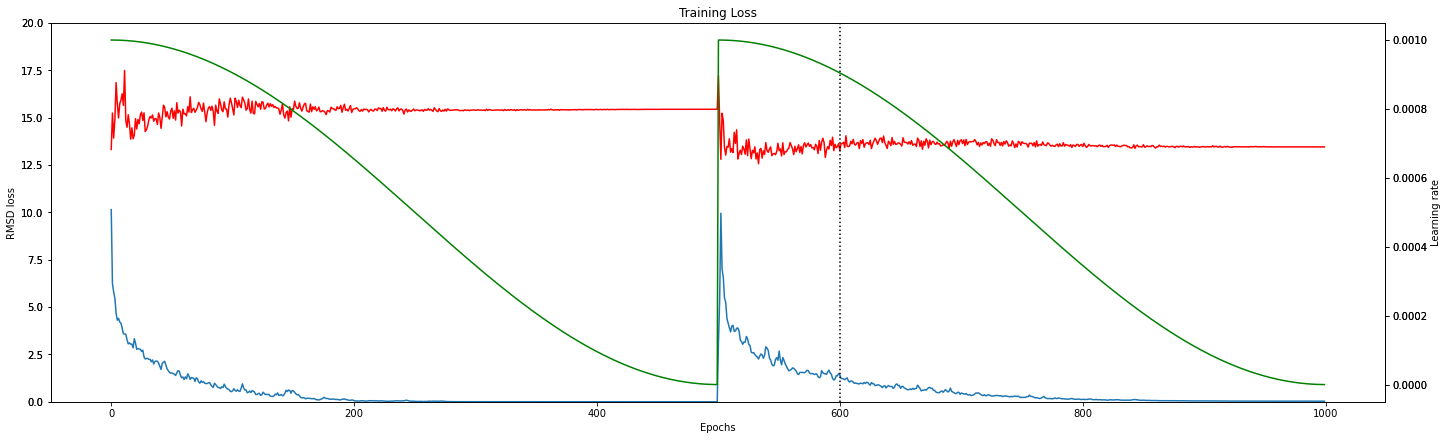

In [38]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = 600, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [17]:
#Test Loop
import math
from pyg_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter

@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred, _, _ = model(test_graph)
        test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item() # l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_graph.y))
        pred_rmsds.append(float(test_pred))

        if test_graph.name[0] in e_dict.keys():
            energies.append(e_dict[test_graph.name[0]])
            prmsds_f_en.append(float(test_pred))
            trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([[21.3180]], device='cuda:0') tensor([[21.3387]], device='cuda:0') 0.00021342607215046883
tensor([[0.]], device='cuda:0') tensor([[28.6048]], device='cuda:0') 28.104782104492188
Mean Test loss: 	 11.2495
Std. Dev. of Test loss:  7.6113
Min loss: 		 0.0002
First Quantile: 	 4.2232
Median: 		 11.2050
Third Quantile: 	 18.4301
Max Loss: 		 28.1048


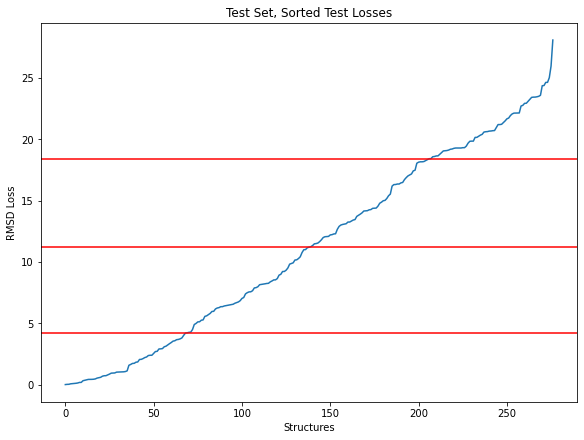

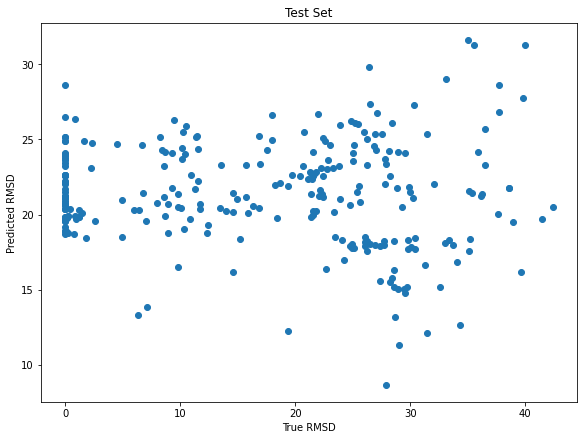

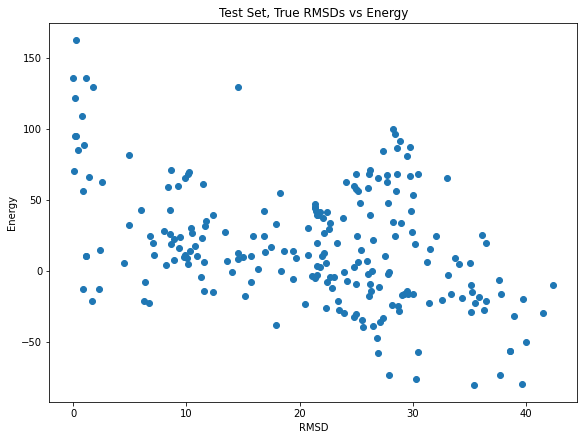

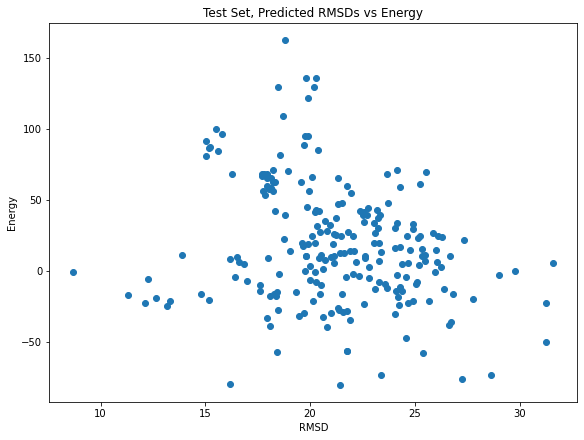

5S and tRNA Test Set
tensor([[2.4280]], device='cuda:0') tensor([[2.4183]], device='cuda:0') 4.7476722102146596e-05
tensor([[0.]], device='cuda:0') tensor([[31.7220]], device='cuda:0') 31.222007751464844
Mean Test loss: 	 6.1463
Std. Dev. of Test loss:  7.7156
Min loss: 		 0.0000
First Quantile: 	 1.2684
Median: 		 3.2642
Third Quantile: 	 7.2120
Max Loss: 		 31.2220


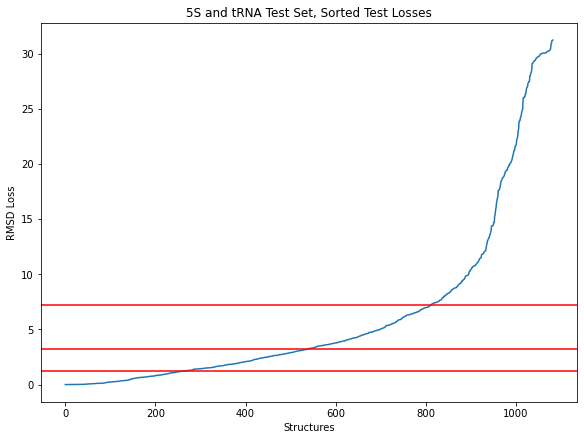

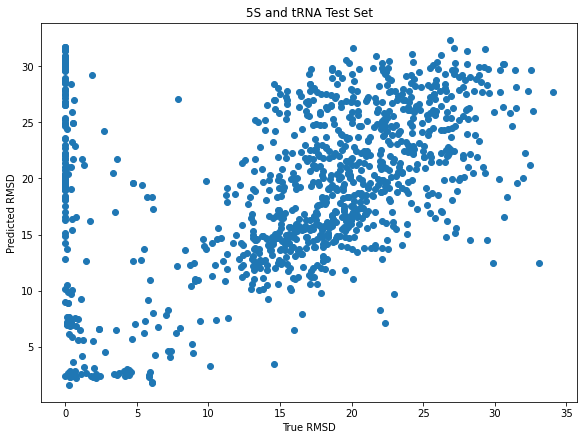

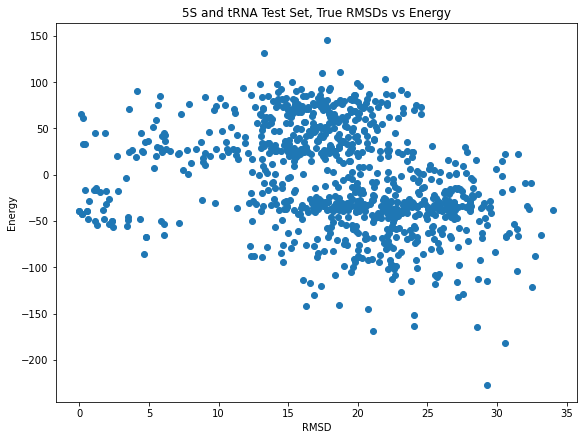

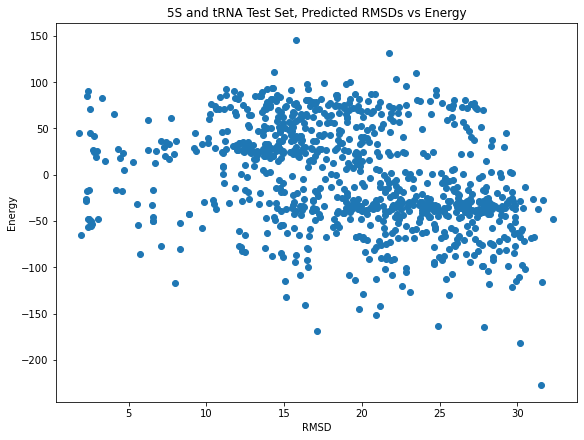

Training Set
tensor([[29.9830]], device='cuda:0') tensor([[29.9808]], device='cuda:0') 2.4518540158169344e-06
tensor([[10.3670]], device='cuda:0') tensor([[24.8058]], device='cuda:0') 13.938834190368652
Mean Test loss: 	 1.1910
Std. Dev. of Test loss:  1.4514
Min loss: 		 0.0000
First Quantile: 	 0.1734
Median: 		 0.6887
Third Quantile: 	 1.6811
Max Loss: 		 13.9388


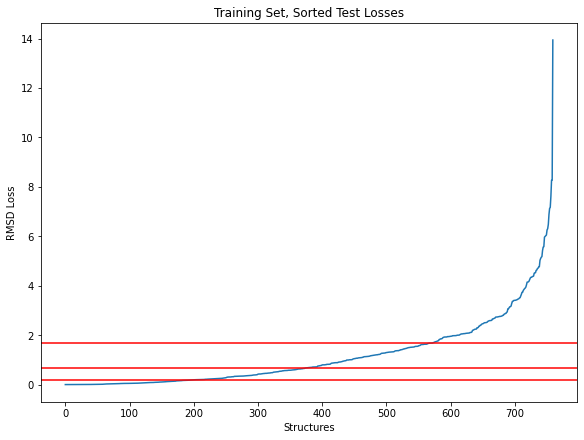

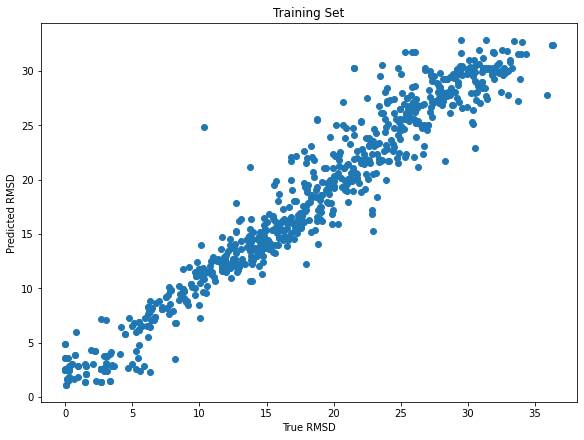

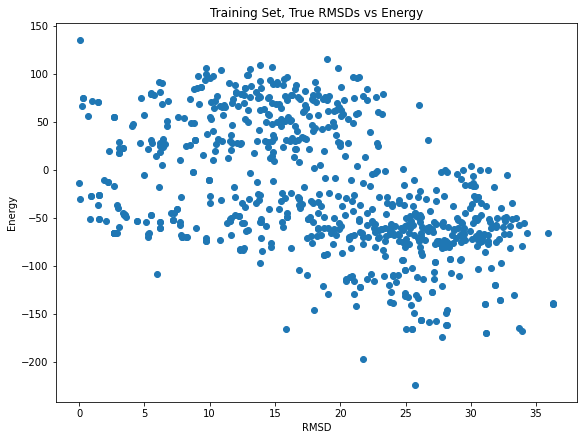

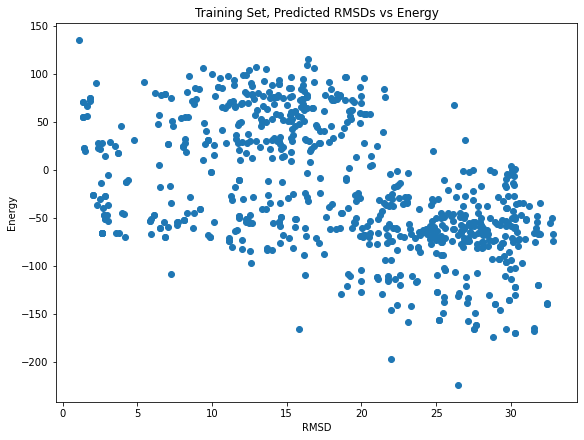

Validation Set
tensor([[20.5760]], device='cuda:0') tensor([[20.5957]], device='cuda:0') 0.00019493000581860542
tensor([[61.9850]], device='cuda:0') tensor([[19.7004]], device='cuda:0') 41.78459930419922
Mean Test loss: 	 13.2808
Std. Dev. of Test loss:  9.4540
Min loss: 		 0.0002
First Quantile: 	 5.7204
Median: 		 10.7201
Third Quantile: 	 20.3264
Max Loss: 		 41.7846


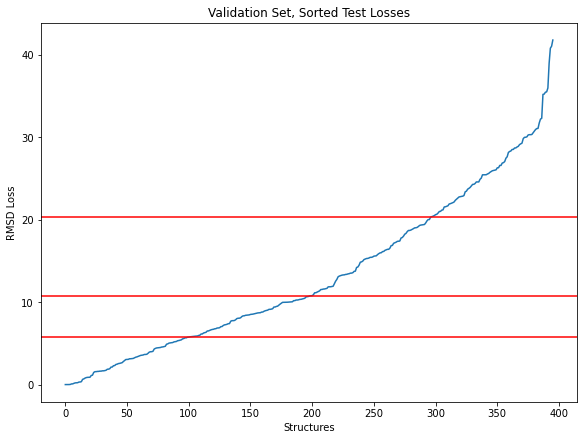

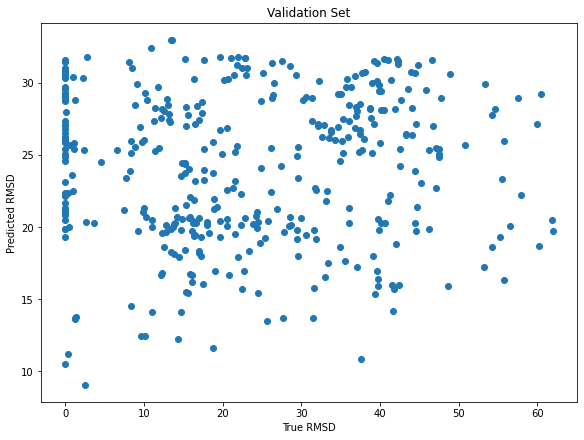

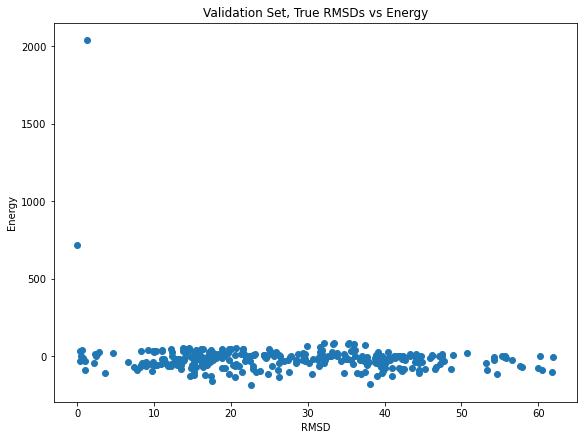

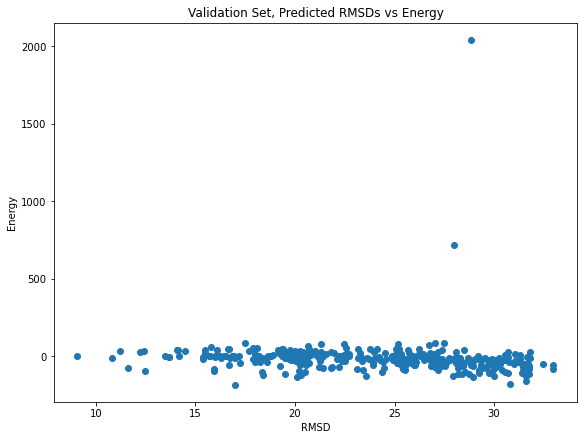

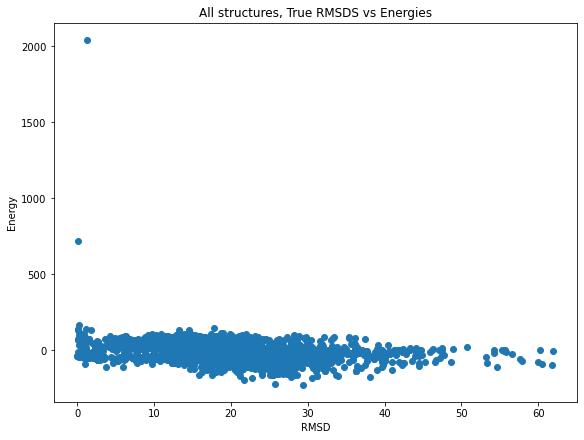

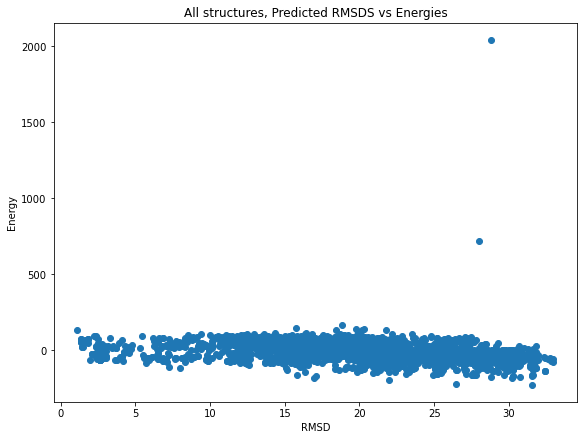

In [39]:
#Test
import math
from pyg_classifier.utility import get_energy_dict

if "model" not in globals():
    model = Diff_CG_Classifier()

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_model_data/model_epoch600.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs = test_loop(model, loader, e_dict, title)
    energy_l += en
    true_rmsd_l += trs
    pred_rmsd_l += prs

e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")

In [9]:
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, transform=T.ToDense(64))

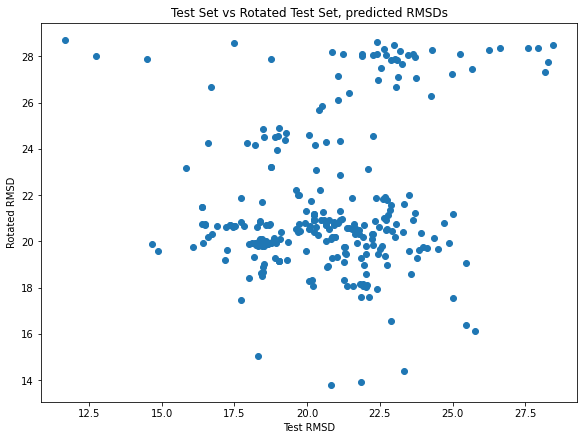

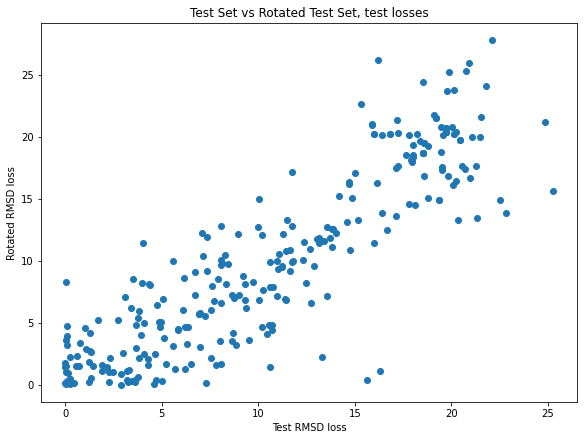

In [37]:
#Test run for rotational invariance
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)

pred_dir = {}
loss_dir = {}
for loader in [test_dataloader, rot_test_dataloader]:
    with th.no_grad():
        model.eval()
        for test_graph in loader:
            test_graph = test_graph.to(device)
            test_pred, _, _ = model(test_graph)
            test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

            if test_graph.name[0] not in pred_dir.keys():
                pred_dir[test_graph.name[0]] = [float(test_pred)]
            else:
                pred_dir[test_graph.name[0]].append(float(test_pred))
            
            if test_graph.name[0] not in loss_dir.keys():
                loss_dir[test_graph.name[0]] = [float(test_loss)]
            else:
                loss_dir[test_graph.name[0]].append(float(test_loss))

test_preds = []
trot_preds = []
for a in pred_dir.keys():
    test_preds.append(pred_dir[a][0])
    trot_preds.append(pred_dir[a][1])

test_ls = []
trot_ls = []
for b in loss_dir.keys():
    test_ls.append(loss_dir[b][0])
    trot_ls.append(loss_dir[b][1])


fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, predicted RMSDs")
axs1.scatter(test_preds, trot_preds)
plt.xlabel("Test RMSD")
plt.ylabel("Rotated RMSD")
plt.show()

fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, test losses")
axs2.scatter(test_ls, trot_ls)
plt.xlabel("Test RMSD loss")
plt.ylabel("Rotated RMSD loss")
plt.show()
